# ABA: Recitation 3

### Spring 2024

In [1]:
# Import required libraries :
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

The Apple app store requires that all apps in the store must display a privacy label. The goal of the privacy label is to inform users about the app’s privacy posture and let them make decision about whether to download the app. There has been a lot of interest in whether privacy labels affect demand  for the app. From December 14 onwards, the Appstore mandated that any new or any existing app must display a privacy label. I am attaching a dataset on the date when the Apps display the label. Apps are followed for a certain number of days and if the label appears then it is listed as 1, otherwise 0. One would expect that labels will appear on or around Dec 14. However, that does not happen. Existing apps do not display privacy labels despite the Appstore mandate. This leads to additional investigating on what factors cause apps to display labels.

In this question, we examine this issue carefully. While there are many useful attributes that may influence the timing for the labels, we focus on rank of the app on Dec 14 and the type of the app (Free, paid, grossing). The Appstore publishes the rank of apps based on how many downloads they receive. A higher rank (1, 2, 3.. and so on) app gets more downloads. We have reasons to believe that top ranked apps are more likely to disclose the label earlier.  

I am attaching a dataset to answer this question. The data provides information on the number of days it takes an App to display the Label. The column “days_followed” lists the number of days the app was followed. The “Label“ column shows whether the label appeared. 

Since the type of apps is a discrete variable, you can run a non-parametric Kaplan Meier test to examine how the probability of label changes with time.   

In [2]:
# read data
filename = 'privacy_label.csv'
df_apps = pd.read_csv(filename)
df_apps

,app_type,days_followed,rank_on_14_Dec,app_category,app_name,Label
0,free,2,58,1,Bible Verses: Daily Devotional,0
1,free,15,52,1,Daily Bible Inspirations,0
2,free,2,85,1,Daily Bible Verse & Motivation,0
3,gross,2,70,1,Daily Devotional For Women App,0
4,gross,6,28,1,Dictionary.com: English Words,0
...,...,...,...,...,...,...
945,gross,4,48,87,RAID: Shadow Legends,1
946,gross,1,32,87,State of Survival Walking Dead,1
947,paid,24,68,87,Superimpose X,1
948,gross,8,68,87,World Series of Poker - WSOP,1


### 1.	Plot Kaplan Meier survival curve for all and then for each type (Free, paid, grossing)

In [3]:
#create fitter for each group
kmf_all = KaplanMeierFitter() 

# we want to fit the duration when the event is "dead"
kmf_all.fit(durations =  df_apps["days_followed"], event_observed = df_apps["Label"],label='all')

<lifelines.KaplanMeierFitter:"all", fitted with 950 total observations, 478 right-censored observations>

Text(0.5, 1.0, 'KMF')

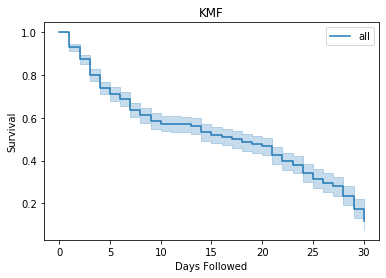

In [4]:
# Plot the survival_function data :
kmf_all.plot()
plt.xlabel("Days Followed")
plt.ylabel("Survival")
plt.title("KMF")

Now for each app type

In [5]:
#create individual dataframes
df_free = df_apps[df_apps.app_type == 'free'].reset_index(drop=True)
df_paid = df_apps[df_apps.app_type == 'paid'].reset_index(drop=True)
df_gross = df_apps[df_apps.app_type == 'gross'].reset_index(drop=True)

In [6]:
#create fitter for each group
kmf_free = KaplanMeierFitter() 
kmf_paid = KaplanMeierFitter() 
kmf_gross = KaplanMeierFitter() 

# we want to fit the duration when the event is "dead"
kmf_free.fit(durations =  df_free["days_followed"], event_observed = df_free["Label"],label='free')
kmf_paid.fit(durations =  df_paid["days_followed"], event_observed = df_paid["Label"],label='paid')
kmf_gross.fit(durations =  df_gross["days_followed"], event_observed = df_gross["Label"],label='gross')

<lifelines.KaplanMeierFitter:"gross", fitted with 409 total observations, 206 right-censored observations>

Text(0.5, 1.0, 'KMF')

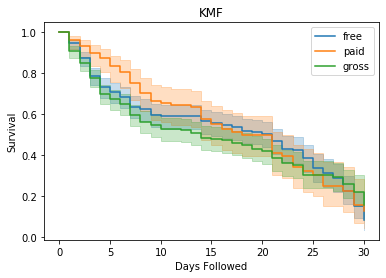

In [7]:
# Plot the survival_function data :
kmf_free.plot()
kmf_paid.plot()
kmf_gross.plot()
plt.xlabel("Days Followed")
plt.ylabel("Survival")
plt.title("KMF")

It seems like there is little difference in the survival functions for the different type of apps. We can do a log rank test to verify the claim.

### 2. Long rank test between free and paid apps

In [8]:
from lifelines.statistics import logrank_test

results = logrank_test(df_free["days_followed"],
                       df_paid["days_followed"],
                       event_observed_A=df_free["Label"],
                       event_observed_B=df_paid["Label"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.64 0.42      1.24

In [9]:
from scipy.stats import chi2

test_statistic = 0.64
df = 1

# Compute the p-value
p_value = 1 - chi2.cdf(test_statistic, df)

print(f"P-value: {p_value:.4f}")

P-value: 0.4237


The test confirms that there is the difference between the survival functions for paid and free apps is not statistically significant

What if we have more than one covariate?

# Estimating the Cox Model

The Cox model allows for the inclusion of covariates and provides a way to estimate the effect of covariates on the hazard function. This makes it possible to adjust for confounding variables and to estimate the effect of multiple covariates simultaneously.

The Cox proportional hazards model deals with the hazard function by modeling it in terms of a baseline hazard and the effect of covariates, without specifying the form of the baseline hazard.

The hazard function, $ h(t|X) $, represents the risk of the event occurring (in our case, displaying the privacy label) at a specific time $ t $, given that the individual has survived up to that time. The Cox model expresses this hazard function as:

$$h(t|X) = h_0(t) \exp(\beta' X)$$

where:
- $h(t|X)$ is the hazard function at time $t $ for an individual with covariates $ X $,
- $ h_0(t) $ is the baseline hazard function, which represents the hazard at time $ t $ for an individual with all covariates equal to zero,
- $ \beta $ is a vector of coefficients, and
- $ X $ is a vector of covariates.

A key feature of the Cox model is that it leaves the baseline hazard function, $ h_0(t) $, unspecified. This means that the model does not make any assumptions about the form of the baseline hazard, which allows for flexibility in modeling the hazard function. Instead of estimating $ h_0(t) $, the Cox model focuses on **estimating the $ \beta $ coefficients**, which indicate how the hazard changes (shifts) with a one-unit increase in the covariates.

By not specifying the baseline hazard, the Cox model is able to provide estimates of the relative hazard (risk) associated with different levels of the covariates, without making any assumptions about the underlying hazard function. This is why the Cox model is referred to as a semi-parametric model: it makes some parametric assumptions (about the effect of the covariates on the hazard), but leaves the baseline hazard unspecified.

When we are more interested in studying how survival varies as a function of explanatory variables (the relative rates) rather than the shape of the underlying hazard function (the absolute rate), then Cox is widely used.



...

Now you want to examine whether the rank of the app on Dec 14 has an impact on when the label is displayed. Bur “rank” is not a discrete variable. So, you decide to estimate a Cox model.  You decide to use rank and types of apps as covariates in the Cox model.

### Write down the Cox model you will estimate and explain what will you estimate.

We will estimate the following:

$$h(t|X) = h_0(t) \exp(\beta_1 \times \text{rank_on_14_Dec} + \beta_2 \times \text{app_type_gross} + \beta_3 \times \text{app_type_paid})$$


The CoxPH model is estimating the impact of the predictor variables (rank_on_14_Dec, app_type_gross, and app_type_paid) on the baseline hazard rate.


***Model***

In [10]:
from lifelines import CoxPHFitter     

In [11]:
#keep columns for regression
cols_to_keep = ['app_type','days_followed','rank_on_14_Dec','Label']
df_cox = df_apps[cols_to_keep].reset_index(drop=True)
df_cox

#get dummies
df_cox = pd.get_dummies(df_cox, drop_first=True) 
#we can't have an estimate for all three app types, so we drop a level free
df_cox.head()

,days_followed,rank_on_14_Dec,Label,app_type_gross,app_type_paid
0,2,58,0,0,0
1,15,52,0,0,0
2,2,85,0,0,0
3,2,70,0,1,0
4,6,28,0,1,0


In [12]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df=df_cox
        ,duration_col='days_followed'
        ,event_col='Label')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 950 total observations, 478 right-censored observations>
             duration col = 'days_followed'
                event col = 'Label'
      baseline estimation = breslow
   number of observations = 950
number of events observed = 472
   partial log-likelihood = -2795.27
         time fit was run = 2024-02-09 05:10:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
rank_on_14_Dec  -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
app_type_gross   0.10       1.10       0.10            -0.10             0.29                 0.90                 1.34
app_type_paid   -0.23       0.80       0.14            -0.50             0.05                 0.61                 1.05

                   z      p   -log2(p)
covariate                             
rank_on_14_Dec -4.98 <0.005      20.61
app_type_gross  0.95   0.34       1.55
app_type_paid  -1.63   0.10       3.28
---
Concordance = 0.59
Partial AIC = 5596.54
log-likelihood ratio test = 28.76 on 3 df
-log2(p) of ll-ratio test = 18.60

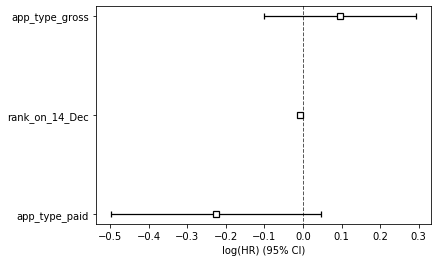

In [13]:
cph.plot()

### Model Fit

Concordance: 0.59

The Concordance statistic is the fraction of all pairs of subjects whose predicted survival times are correctly ordered among all pairs. It measures the predictive power of the survival model. A Concordance of 0.5 suggests that the model's predictions are no better than random chance, while a Concordance of 1.0 indicates perfect discrimination. A value of 0.59 suggests that the model has some predictive power, but not very strong.

Internally, it's:

(pairs_correct + 0.5 * pairs_tied) / admissable_pairs

read more: https://lifelines.readthedocs.io/en/latest/lifelines.utils.html

Partial AIC:	5596.54

The Akaike Information Criterion (AIC) is a measure used to compare different models. Smaller values of AIC suggest a better model fit to the data. In isolation, the provided value doesn't tell us much, but if comparing multiple models, you'd generally prefer the model with the lower Partial AIC.

It is calculated as:
- AIC = 2k - 2 (partial Log Likelihood)
- Where k is the number of parameters.


log-likelihood ratio test	28.76 on 3 df

The Log-Likelihood Ratio Test is used to compare the fit of two models: one simpler (null model) and one more complex (the model with the predictors). A significant p-value for the test suggests that the more complex model (with the predictors) provides a better fit to the data than the simpler model. The test statistic is 28.76, with 3 degrees of freedom (which corresponds to the number of predictors added to the null model). The provided "-log2(p) of ll-ratio test" value of 18.60 translates to a significant p-value (-log2(p)=1 corresponds to p-value of 0.05)

In [15]:
from scipy.stats import chi2

test_statistic = 28.76
df = 3

# Compute the p-value
p_value = 1 - chi2.cdf(test_statistic, df)

print(f"P-value: {p_value:.4f}")

P-value: 0.0000


In [16]:
import numpy as np

value = p_value  # p-value
neg_log2_value = -np.log2(value)
print(neg_log2_value)

18.60093143387249


### Interpeting the estimates

We observe that coefficient for rank is stasticially significant

- rank_on_14_Dec: For a unit increase in the rank of the app, the hazard decreases by close to 1 percent. The coefficient is statistically significant with a p-value of <0.005. We can then conclude that a worse rank leads to a lower "risk" of label disclosure
- app_type_gross: For apps in the "Gross" type the hazard increases by  close to 10 percent relative to apps of type "Free". However, given the p-value(0.34), this effect is not statistically significant.
- app_type_paid: For apps in the "Paid" type the hazard decreases by close to 23 percent relative to apps of type "Free". However, given the p-value (0.1), this effect is not statistically significant.


### Test the proportionality assumption in the model

The proportional hazards test is used to test the proportional hazards assumption of the Cox proportional hazards model. This assumption states that the hazard of the event of interest for one individual is proportional to the hazard of any other individual, and this proportionality is constant over time.

The test statistic for this test follows a chi-square distribution under the null hypothesis that the proportional hazards assumption is true. A significant p-value (usually less than 0.05) indicates that the proportional hazards assumption is violated for that covariate.

In [17]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, df_cox,time_transform='km')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = km
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 950 total observations, 478 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
app_type_gross            4.69 0.03      5.04
app_type_paid             4.07 0.04      4.52
rank_on_14_Dec            2.02 0.16      2.69

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 950 total observations, 478 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
app_type_gross km              4.69   0.03      5.04
               rank            0.57   0.45      1.15
app_type_paid  km              4.07   0.04      4.52
               rank            9.98 <0.005      9.30
rank_on_14_Dec km              2.02   0.16      2.69
               rank            2.66   0.10      3.28

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]




1. Variable 'app_type_gross' failed the non-proportional test: p-value is 0.0303.

   Advice: with so few unique values (only 2), you can include `strata=['app_type_gross', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]



2. Variable 'app_type_paid' failed the non-proportional test: p-value is 0.0016.

   Advice: with so few unique values (only 2), you can include `strata=['app_type_paid', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<matplotlib.axes._subplots.AxesSubplot at 0x7f84f5a48e50>,

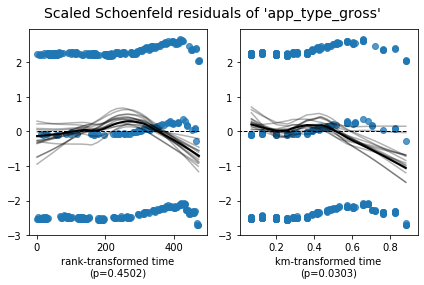

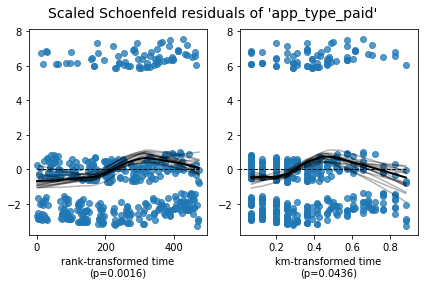

In [18]:
cph.check_assumptions(df_cox, p_value_threshold=0.05,  show_plots =  True) 

Hazards for each app type might not be the same!

More details in residuals:
https://timeseriesreasoning.com/contents/schoenfeld-residuals/

# Stratify

We let the hazard be different between subgroups. Then, we can estimate different hazard for each strata. We are allowing different hazards for the variable "app_type". We are estimating:

$h(t|X) = h_{0apptype=free} \exp(\beta_1 \times \text{rank_on_14_Dec})$

$h(t|X) = h_{0apptype=gross} \exp(\beta_1 \times \text{rank_on_14_Dec})$

$h(t|X) = h_{0apptype=paid} \exp(\beta_1 \times \text{rank_on_14_Dec})$


In [21]:
#keep columns for regression
cols_to_keep = ['app_type','days_followed','rank_on_14_Dec','Label']
df_cox = df_apps[cols_to_keep].reset_index(drop=True)
df_cox


,app_type,days_followed,rank_on_14_Dec,Label
0,free,2,58,0
1,free,15,52,0
2,free,2,85,0
3,gross,2,70,0
4,gross,6,28,0
...,...,...,...,...
945,gross,4,48,1
946,gross,1,32,1
947,paid,24,68,1
948,gross,8,68,1


In [23]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df=df_cox
        ,duration_col='days_followed'
        ,event_col='Label'   ## Fit the data to train the model
        ,strata=['app_type'] )#include strata 
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 950 total observations, 478 right-censored observations>
             duration col = 'days_followed'
                event col = 'Label'
                   strata = ['app_type']
      baseline estimation = breslow
   number of observations = 950
number of events observed = 472
   partial log-likelihood = -2320.08
         time fit was run = 2024-02-09 06:29:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
rank_on_14_Dec  -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99

                   z      p   -log2(p)
covariate                             
rank_on_14_Dec -5.23 <0.005      22.47
---
Concordance = 0.59
Partial AIC = 4642.16
log-likelihood ratio test = 28.36 on 1 df
-log2(p) of ll-ratio test = 23.24

In [24]:
cph.check_assumptions(df_cox, p_value_threshold=0.05,  show_plots =  True) 

Proportional hazard assumption looks okay.


/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]